# Week 7: Natural language processing

The exercises today are about extracting high-level knowledge from text. We're still a long way from computers being able to give us insight as deep as that which we can aquire from manually reading text, but some the tools that you will use today get us a long way in understanding useful things about unreadibly large amount of text in comparatively little time. In the exercises today you will:

* Create wordclouds
* Extract sentiment from text
* Construct a Bag of Words (BoW) matrix to represent how words are used about each faction in the Marvel dataset
* Perform a TD-IDF transform to understand which words are important to different characters

[**Feedback**](http://ulfaslak.com/vent)

## Exercises

### Part 1 (Extra): Wordcloud

Although they probably offer more buzz than usefulness, wordclouds are a fun way to get quick insight into which words are used in a corpus of text. In this section you will generate one.

>**Ex. 7.1.1**: To make a word cloud you need some more or less clean text. For each character extract as cleanly as you can, the text written on their wikipage. Since the wikidata is kind of messy, there are some things you should be aware of when extracting the text.
* Exclude character names.
* Exclude links.
* Exclude numbers.
* Set everything to lower case.
* Do not include stopwords (use `nltk.corpus.stopwords.words("english")` to get a list of stopwords; install `nltk` to do this).

>Cleaning doesn't have to be perfect and can be done in a many different ways, these are just some things to look out for.

>Once you have extracted the text, create one long text string for all text written about heroes, another long text string for villains, and finally one for ambiguous characters. Using the code snippet below which shows how to plot a word cloud, plot the word clouds for each faction.

>        text = "some cool text"
>        wc = wordcloud.WordCloud(max_font_size=40).generate(text)
>        
>        plt.figure()
>        plt.imshow(wc, interpolation="bilinear")
>        plt.axis("off")
>        plt.show()

> You have to import `matplotlib.pylab` and `wordcloud` to do this. You can install `wordcloud` with anaconda by typing into your console

>        conda install -c conda-forge wordcloud

>or

>        pip install wordcloud

>if you don't have Anaconda installed.

Helper function to get vector of words for a character. Make sure the path to your data is correct.

In [226]:
import re
import nltk
import os

#nltk.download('stopwords')

# Get a list of stopwords from nltk
stopwords = nltk.corpus.stopwords.words("english")

def get_clean_words(character_filename, faction):
    def _isnum(w):
        try:
            int(w)
            return True
        except ValueError:
            return False
        
    # Load her markup
    with open("./data/%s/%s" % (faction, character_filename)) as fp:
        markup = fp.read()

    # Remove table and external links
    markup_text = re.sub(r'\{\{[\s\S]*?\}\}', '', markup)

    # Remove category links
    markup_text = re.sub(r'\[\[Category.+\]\]', '', markup_text)

    # Set words to lowercase and remove them if they are stop words
    words = [w.lower() for w in re.findall('\w+', markup_text) if w.lower() not in stopwords]

    # Remove numbers
    words = [w for w in words if not _isnum(w)]

    return words

# Example
#get_clean_words("Iron Man.txt", "heroes")

In [219]:
def extract_marvel_text():
    
    faction_text = {'heroes': [], 'villains': [] , 'ambiguous': []}
    
    for faction in ["heroes", "ambiguous", "villains"]:
        faction_chars = [c[:-4] for c in os.listdir("./data/%s" % faction)]
   
        for char in faction_chars:
            text_file = char+".txt"
            
            words = get_clean_words(text_file,faction)
            
            for w in words: 
                if w != char and w != 'ref':
                    faction_text[faction].append(w)
               
    return faction_text
        
        
faction_text = extract_marvel_text()

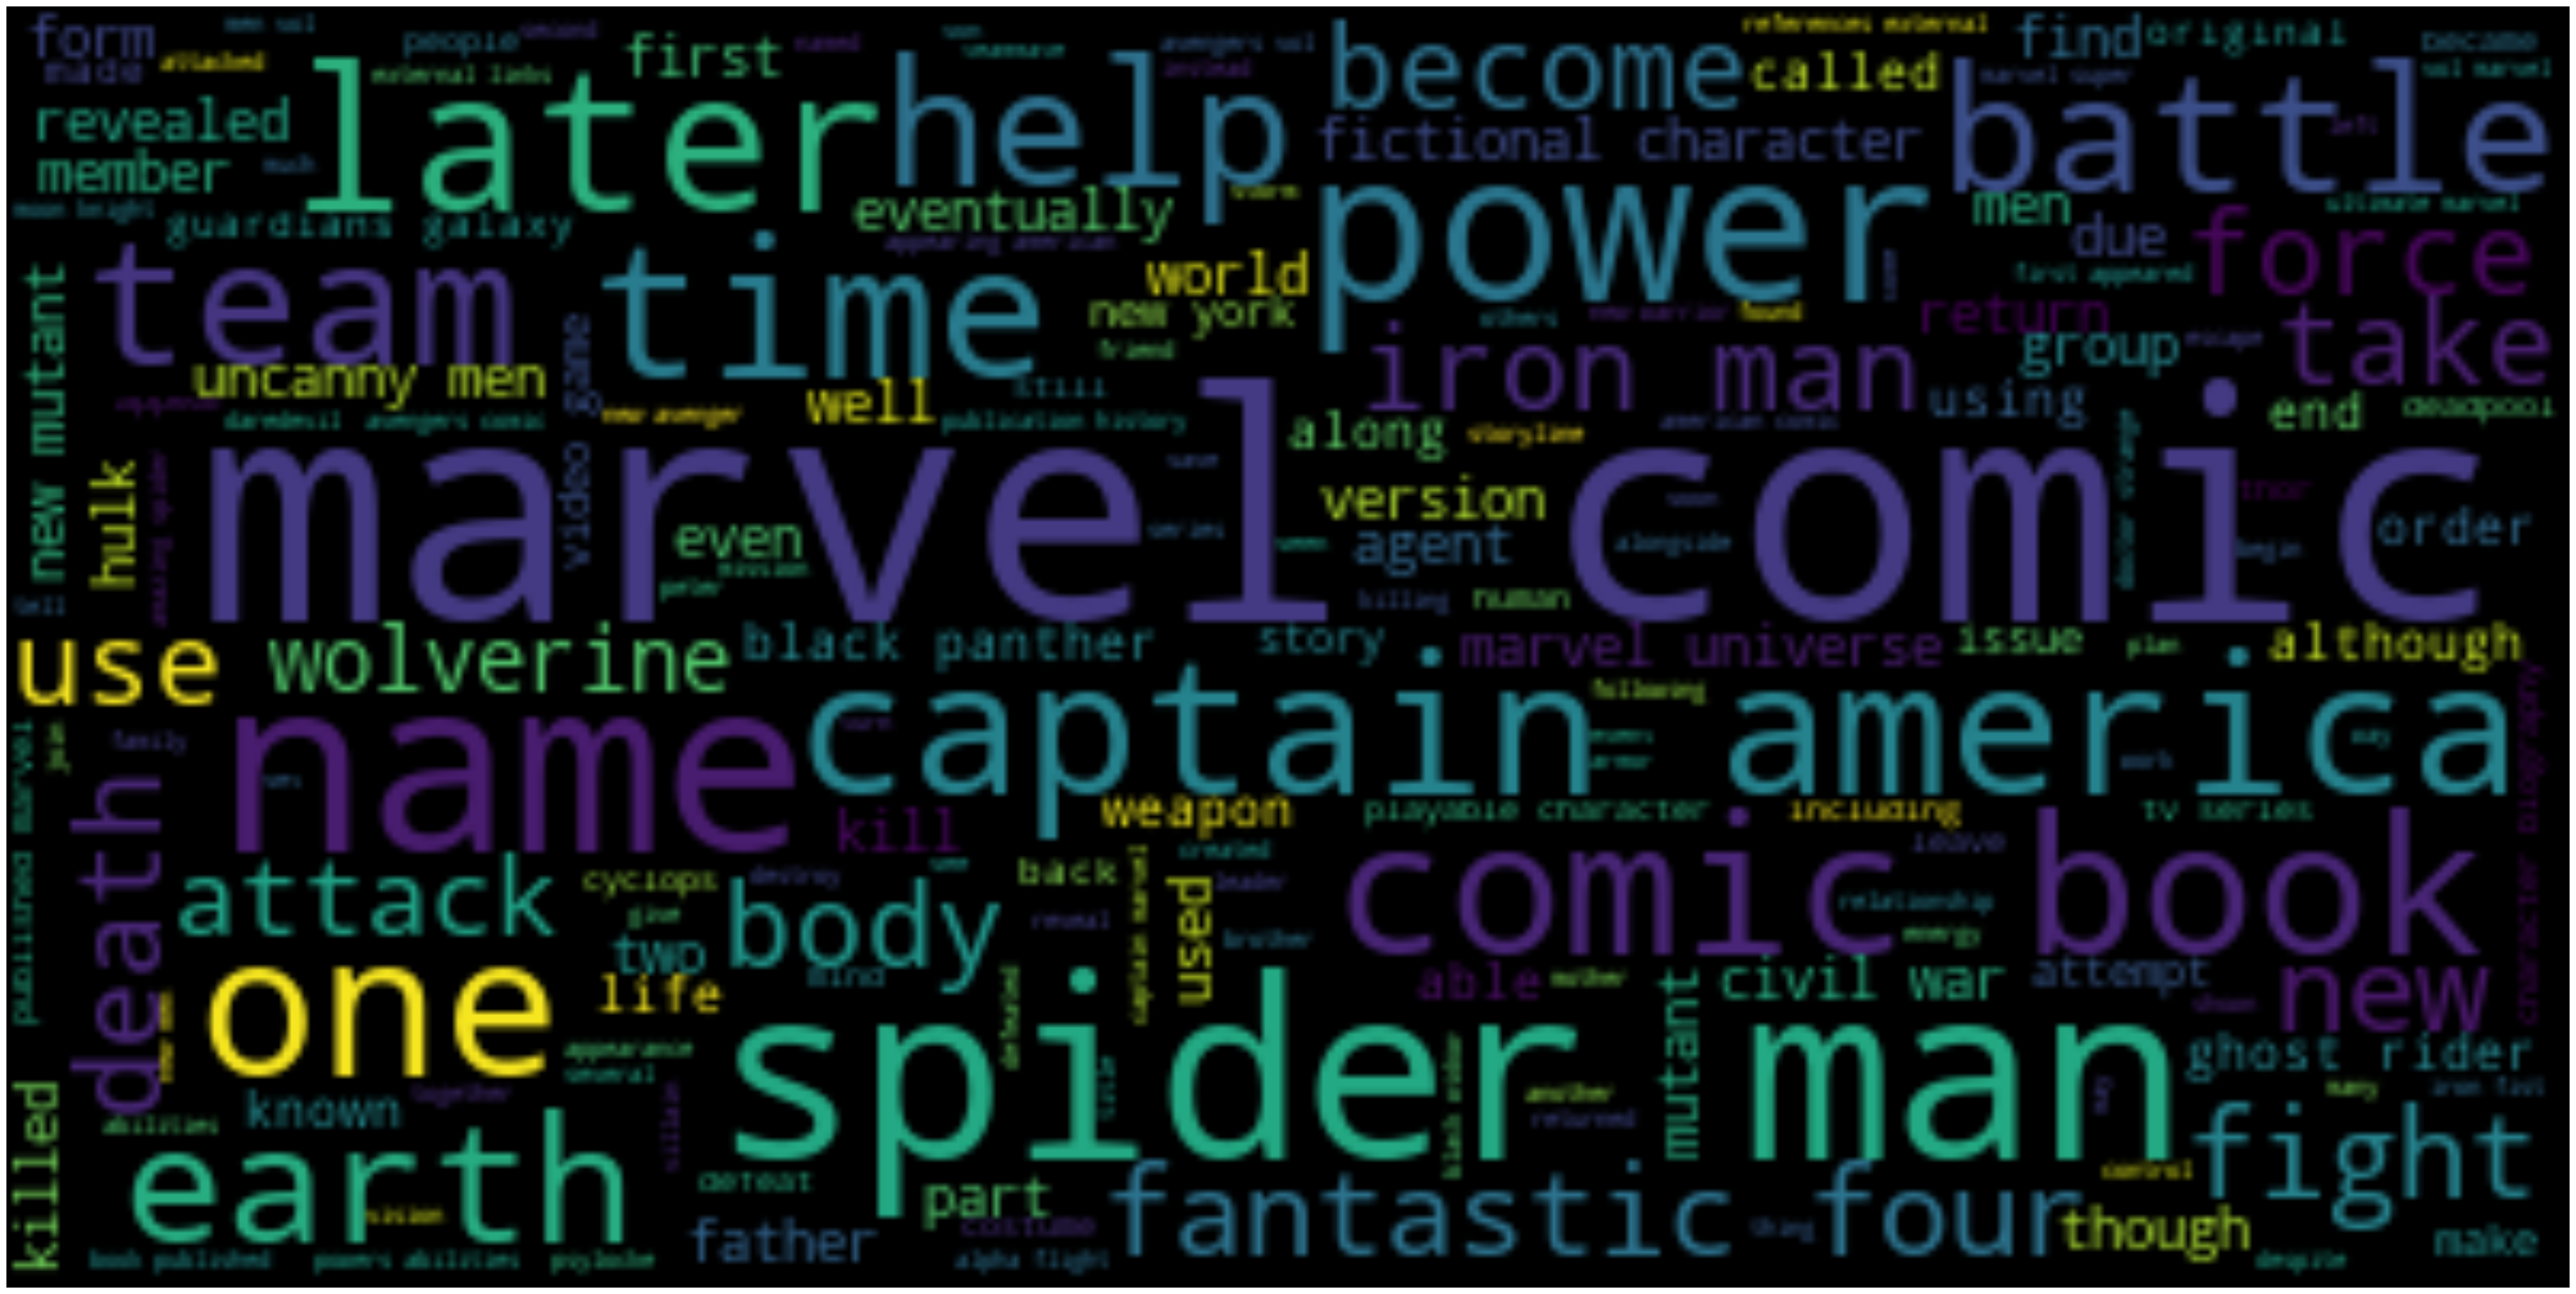

In [220]:
import wordcloud
import matplotlib.pyplot as plt

wc = wordcloud.WordCloud(max_font_size=50).generate(' '.join(faction_text['heroes']))

plt.figure(figsize=(50,50))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

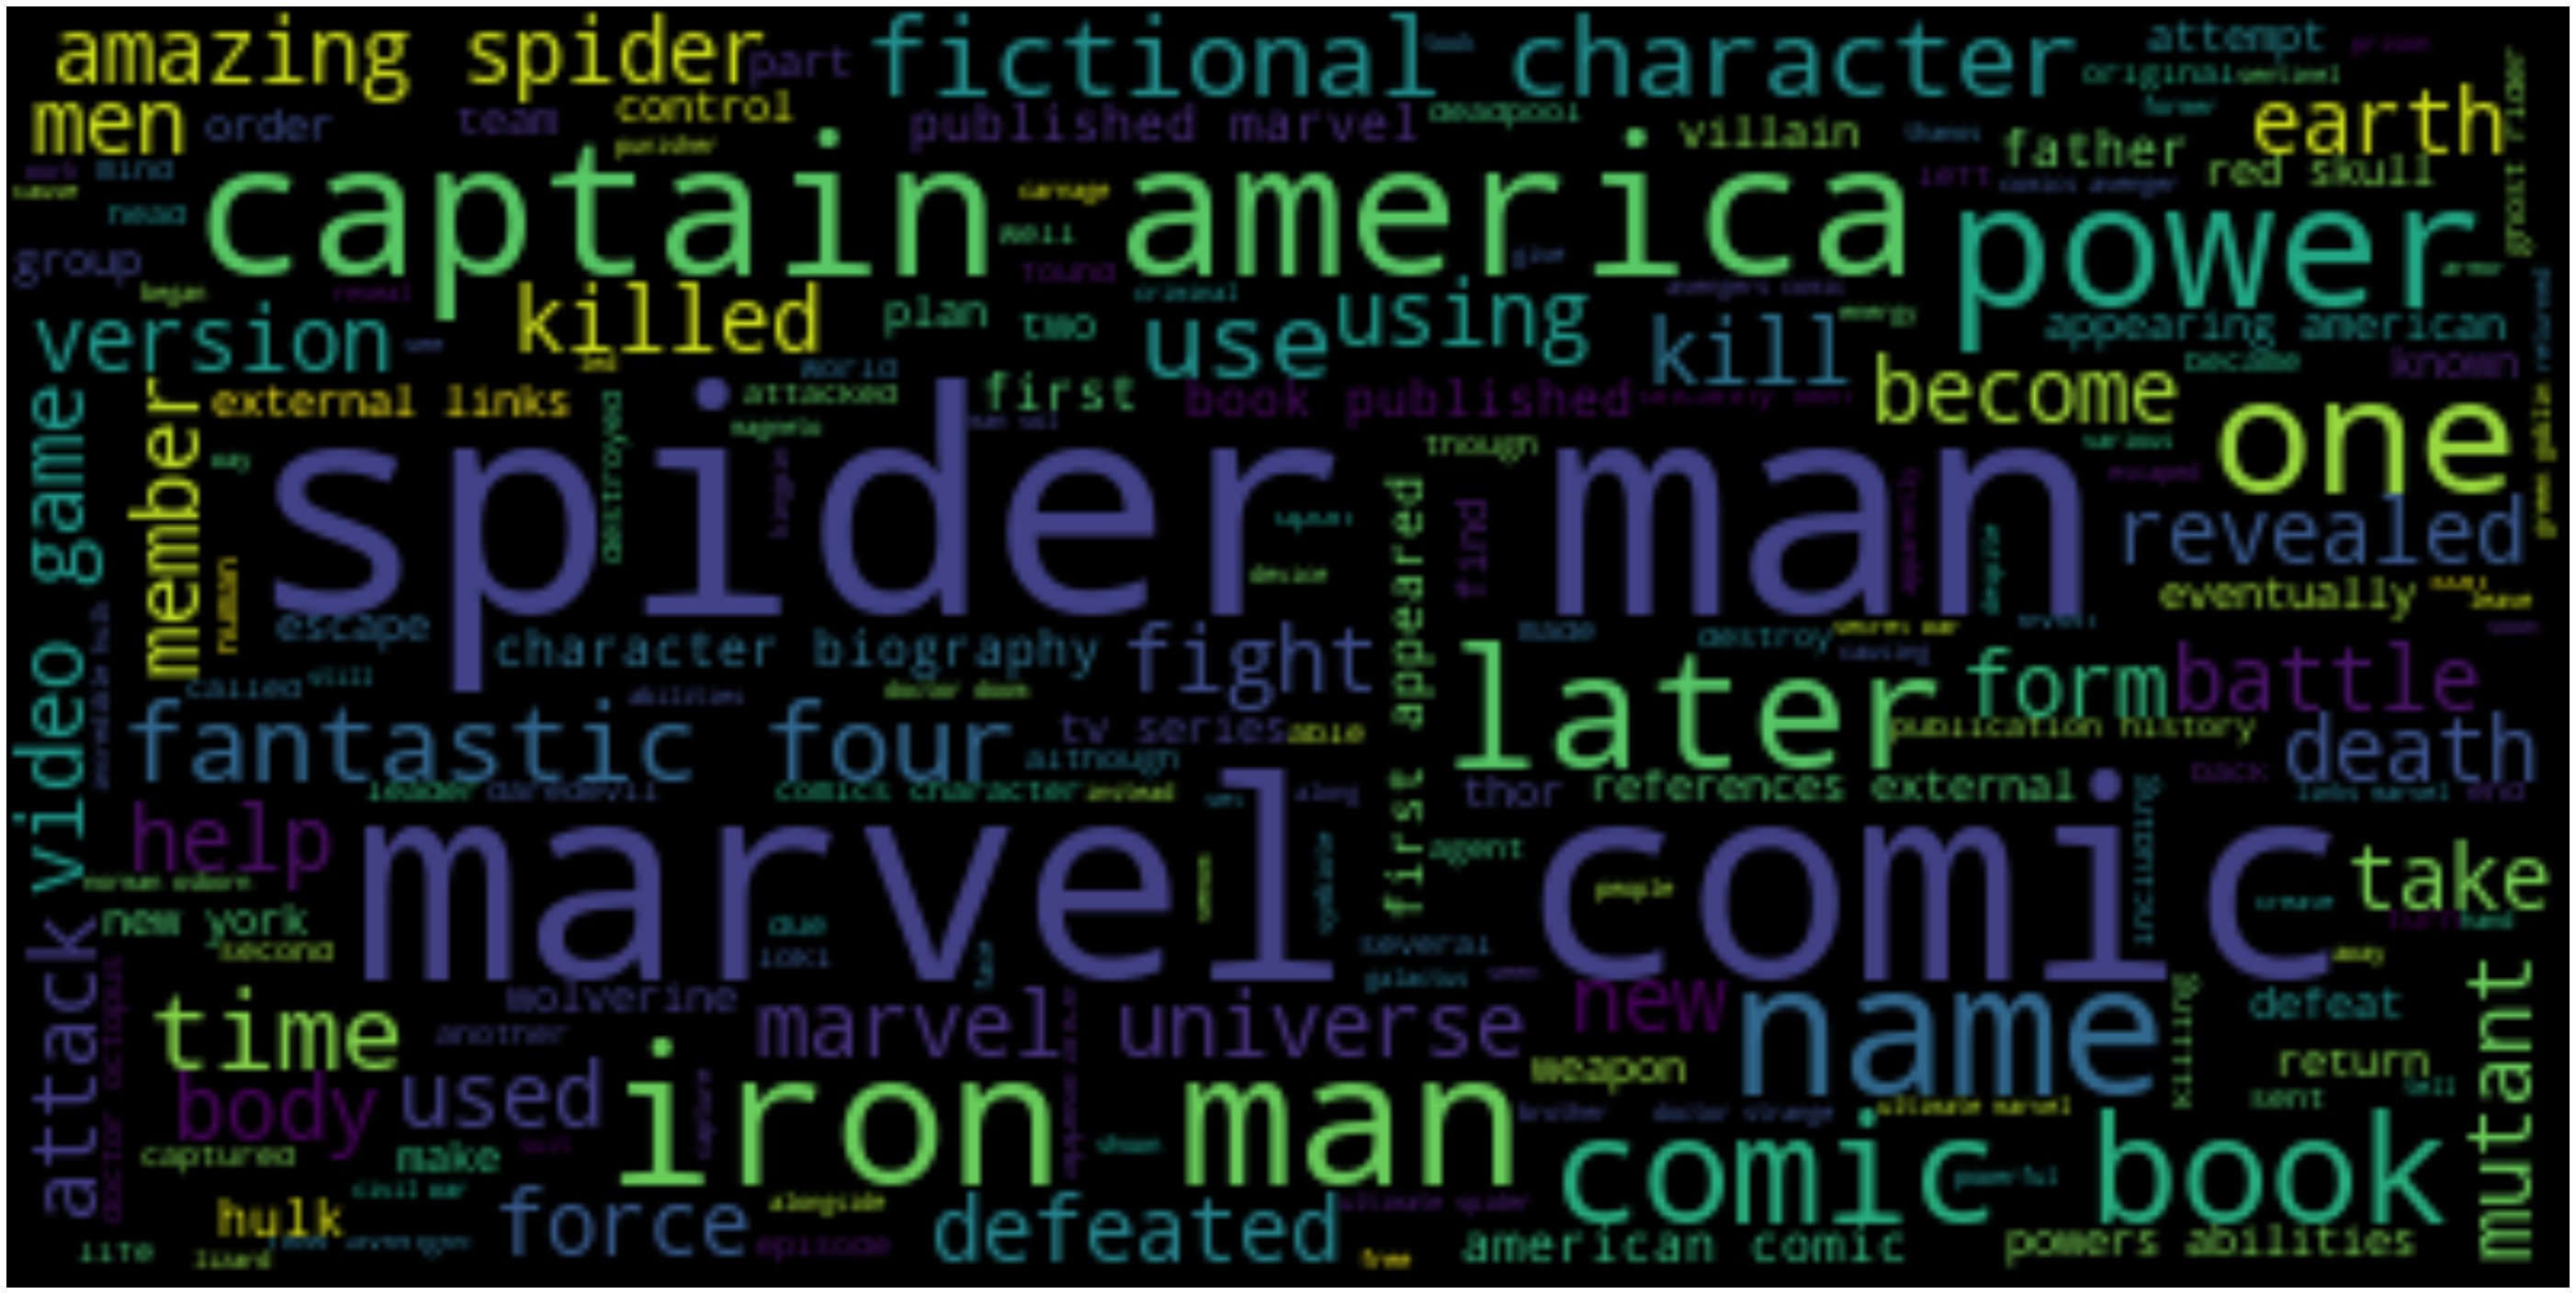

In [221]:
wc = wordcloud.WordCloud(max_font_size=50).generate(' '.join(faction_text['villains']))

plt.figure(figsize=(50,50))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

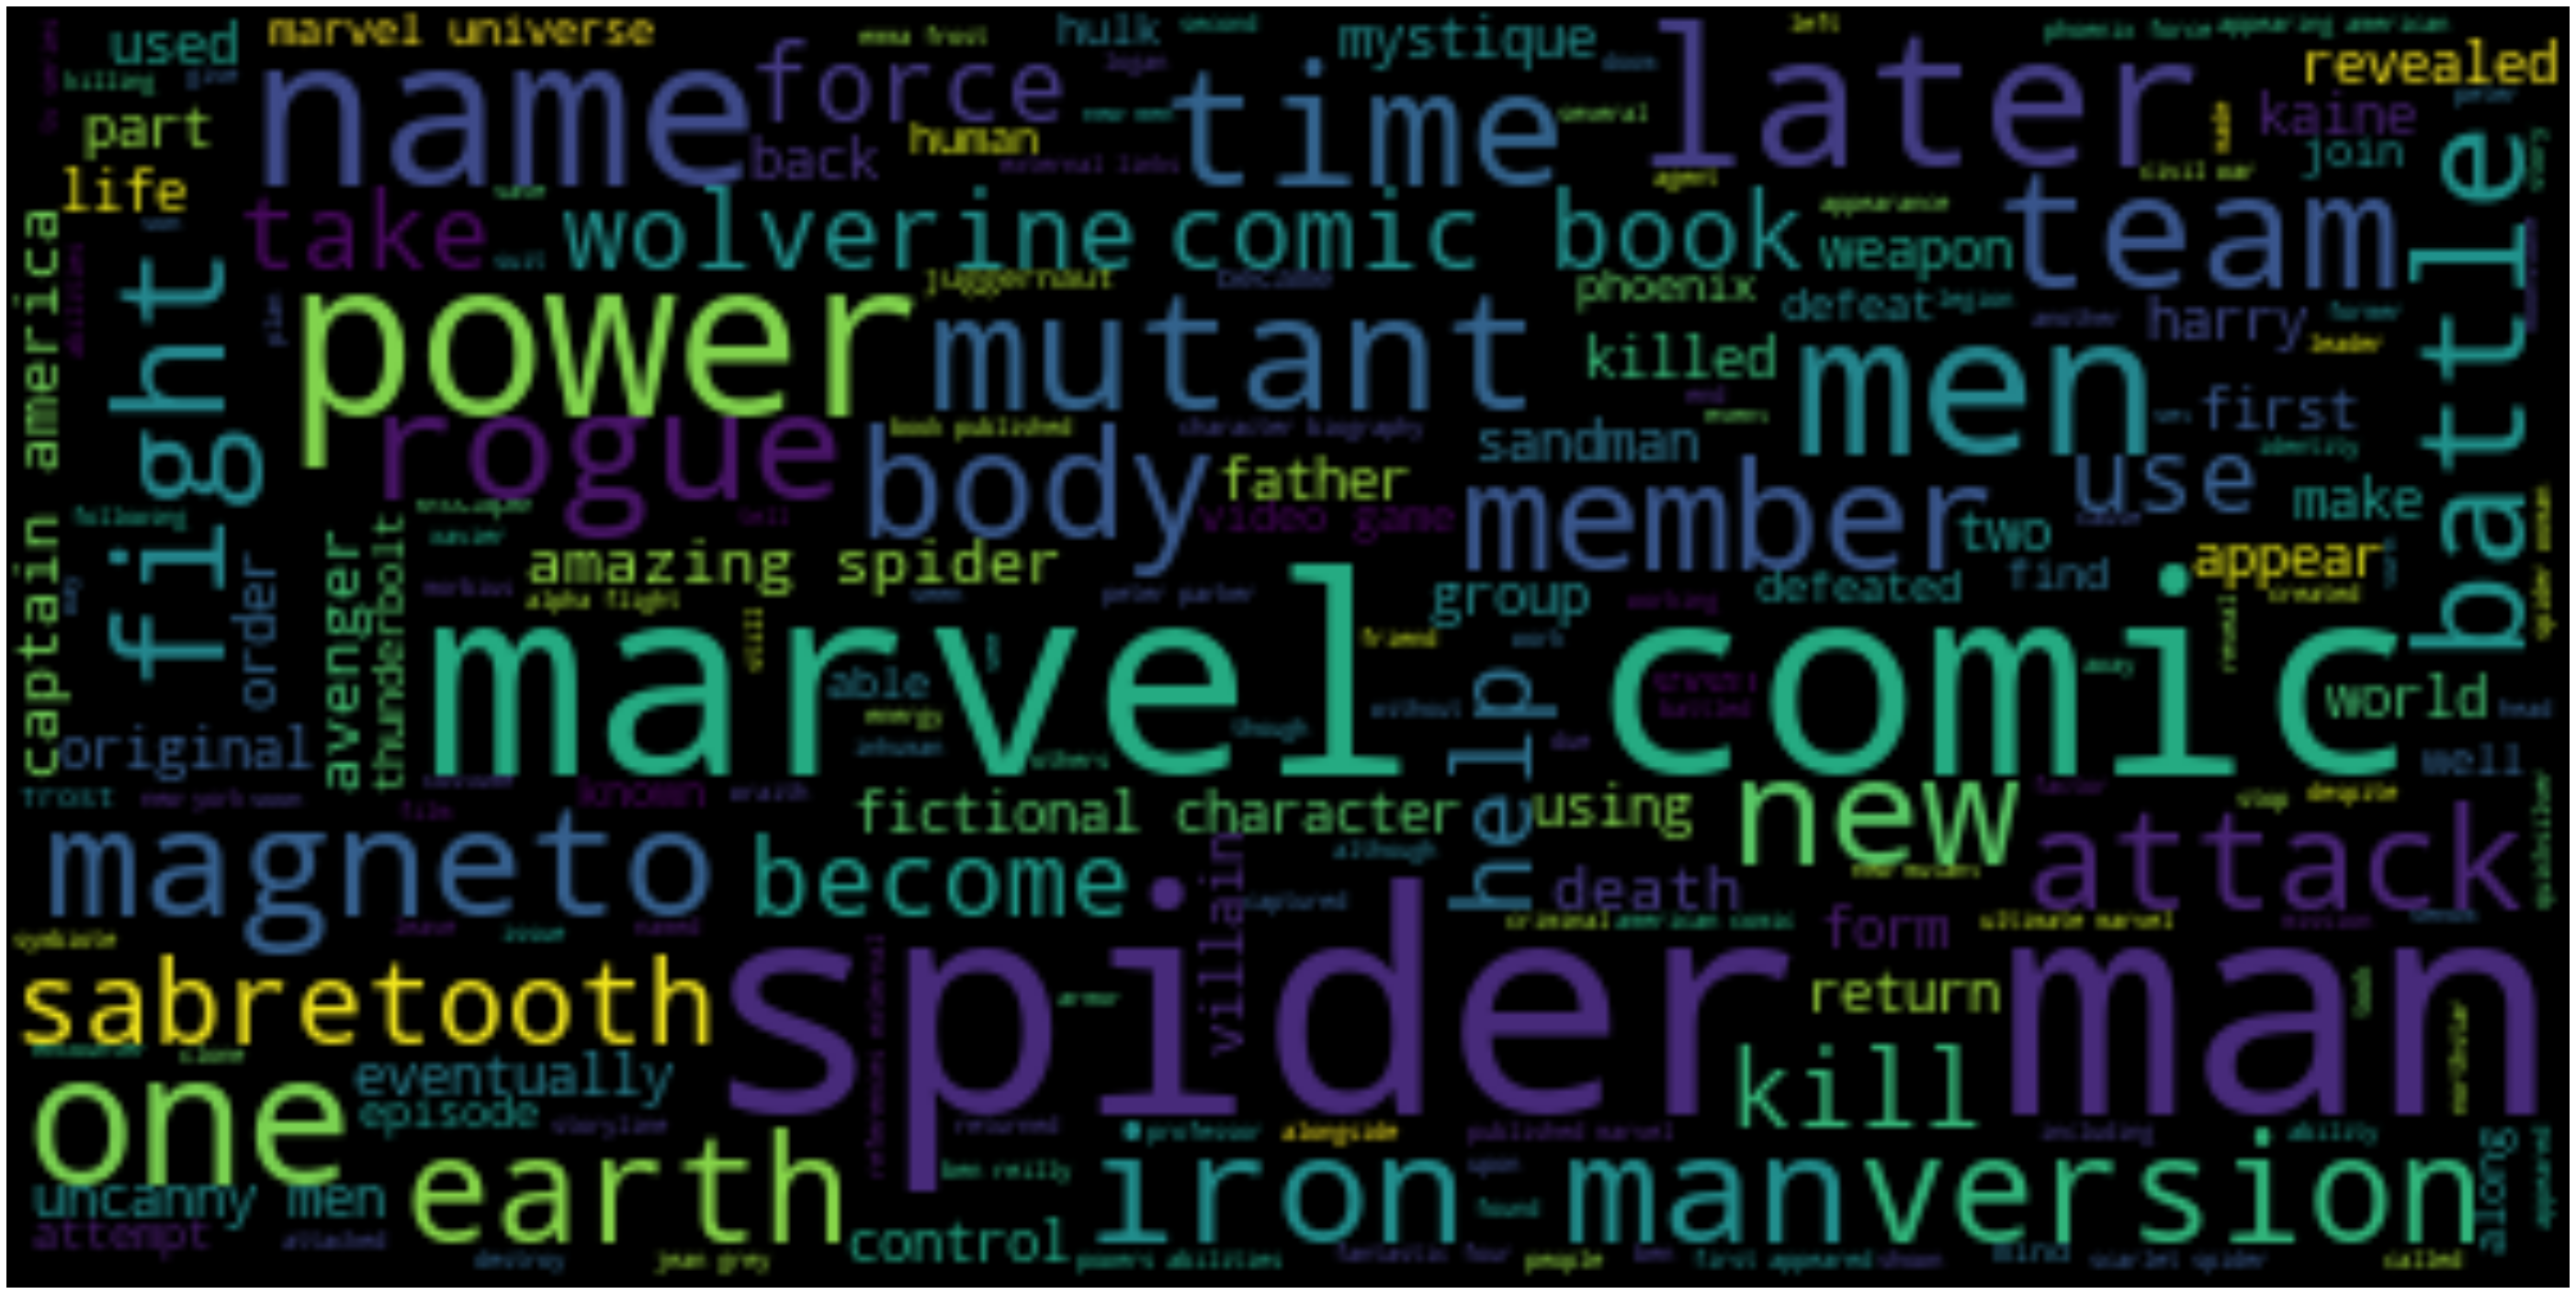

In [222]:
wc = wordcloud.WordCloud(max_font_size=50).generate(' '.join(faction_text['ambiguous']))

plt.figure(figsize=(50,50))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

### Part 2: Sentiment analysis

Often you don't have time to read some text, but you need to know something about whether it positively or negatively toned. Enter *Sentiment Analysis*. The point of this exercise is to extract the sentiment of text on your heroes, villains and ambiguous characters and figure out whether Wikipedia is biased towards writing in a certain tone towards a certain kind of characters.

>**Ex. 7.2.1**: For each of the three character classes, compute the sentiment scores across wikipedia articles so that you can produce three histograms (one for each class) with sentiment scores. You can use the text strings you generated in the previous exercise. We will cheat a bit and use a library that does the scoring for us. Install `afinn` using `conda` or `pip` and extract the sentiment with that module. There's an example of how to use it on the library's [PyPi repository](https://pypi.python.org/pypi/afinn).

In [224]:
from afinn import Afinn
afinn = Afinn()

hero_text = ' '.join(faction_text['heroes'])
ambig_text = ' '.join(faction_text['ambiguous'])
villain_text = ' '.join(faction_text['villains'])

hero_score = afinn.score(hero_text)
villain_score = afinn.score(villain_text)
ambig_score = afinn.score(ambig_text)

all_scores = [hero_score, villain_score, ambig_score]

In [225]:
print(hero_score)
print(villain_score)
print(ambig_score)

18770.0
-8475.0
-2535.0


### Part 3: Bag of Words matrix

Intuitively, "Bag of Words" means breaking up a document into words and throwing them into a bag. And that's very close to the truth! In week 5 you constructed a "team-affiliations" matrix which had a row for each character and a column for each team. If the character was on a given team there would be a one for that character row at that team column, if not there would be a zero. The BoW is the same, only now, rather than teams, your columns are individual words that a character's wikipage might contain, and the numbers represent how many times those words appear.
<img src="http://ulfaslak.com/computational_analysis_of_big_data/exer_figures/example_bow.png" width="400"/>
BoW's are pretty large and sparse (mostly contain zero's) matrices, but they are extremely useful because they allow us to use linear algebra to do things like PCA, classification, etc..

>**Ex. 7.3.1**: Create a bag of words matrix that contains all your characters. Maintain also a target array, so you know whether a row corresponds to a hero, a villain or an ambiguous character. Do not include stopwords like "is", "a", etc. (get list of stopwords from `nltk.corpus.stopwords.words("english")`). Also, do not include words that only appear for one character.
1. How many different words are in your vocabulary/columns are in your matrix?
2. Print the 10 most used words, and the 10 least used words, along with their usage count.
3. Plot the distribution of how many times words are used.

>*Hint: Since you already extracted lists of words for each faction in Ex. 7.1.1, you can use these to figure out what the total vocabulary of words used in your dataset is. You can "clean up" this vocabulary by a number of tricks. For example, there are tools for *stemming* words to remove grammar so that e.g. 'cat' and 'cats' both become 'cat', but that's all up to you whether you wanna go that deep.*

In [227]:
#for stemming words
from nltk.stem.porter import *
from nltk.corpus import words

dictionary = words.words()

#get list of unique words for matrix
def construct_word_list():
    
    stemmer = PorterStemmer()
    wordSet = set([])
    wordList = []
    #special characters to ommit
    string_check= re.compile('[@_!#$%^&*()<>?/\|}{~:]')
    
    for faction in ["heroes", "ambiguous", "villains"]:
        faction_chars = [c[:-4] for c in os.listdir("./data/%s" % faction)]
   
        for char in faction_chars:
            text_file = char+".txt"
            
            words = get_clean_words(text_file,faction)
            
            for w in words:
                w = stemmer.stem(w)
                #ommit stopwords, character names and words starting with numbers
                if w != char and w != 'ref' and w not in stopwords and w[0] > 'A':
                
                    #check for special characters
                    if(string_check.search(w) == None): 
                        wordSet.add(w)
                        
    wordSet = sorted(wordSet)
    
    for w in wordSet:
        wordList.append(w)
        
    return wordList, wordSet

In [228]:
wordList, wordSet = construct_word_list()

In [229]:
wordList

['a1',
 'a12f9c662597e40c6284b7dd7d910014',
 'a17',
 'a187',
 'a26',
 'a28',
 'a3ac',
 'a482264',
 'a6731256',
 'a78',
 'a79',
 'a80',
 'a841356',
 'a9avwn6',
 'aa',
 'aa1',
 'aa5',
 'aa6',
 'aaaaaaaaae',
 'aaaaaaaac1g',
 'aaaaaaaafwi',
 'aaakurs',
 'aaargh',
 'aahero',
 'aaidan',
 'aakok',
 'aakon',
 'aam2',
 'aamish',
 'aan',
 'aardi',
 'aardvark',
 'aardwolf',
 'aarku',
 'aaron',
 'aaronson',
 'aaronstack',
 'aav2no4',
 'aav2no5',
 'aback',
 'abandon',
 'abat',
 'abattoir',
 'abaya',
 'abbey',
 'abbi',
 'abbot',
 'abbott',
 'abbrevi',
 'abc',
 'abcissa',
 'abcnew',
 'abdic',
 'abdol',
 'abdomen',
 'abdomin',
 'abdoul',
 'abduct',
 'abducte',
 'abductor',
 'abdul',
 'abe',
 'abel',
 'abergylid',
 'aberr',
 'abet',
 'abhorr',
 'abi',
 'abid',
 'abidemi',
 'abiet',
 'abigail',
 'abil',
 'abilitit',
 'abject',
 'abl',
 'ablaz',
 'ablemarl',
 'ablo',
 'abner',
 'abnett',
 'abnorm',
 'abo',
 'aboard',
 'abod',
 'aboena',
 'abolish',
 'abolit',
 'abomin',
 'abominatrix',
 'abominoid',
 'ab

In [215]:
def get_target_list():

    target_list = []

    for faction in ['heroes', 'villains', 'ambiguous']:
        for char_filename in os.listdir('./data/%s/' % faction):
            char_name = char_filename[:-4]
            target_list.append([char_name, faction])

    target_list.sort()

    return target_list

target_array = np.array(get_target_list())

target_array_char = target_array[:,0] # list of chars
target_array_faction = target_array[:,1] # list of faction

In [231]:
import numpy as np

#VERY SLOW RUN TIME
def construct_bow(wordList, wordSet):
    charList = []
    stemmer = PorterStemmer()
    matrix = np.empty(shape=(len(target_array_char), len(wordList)))
    #special characters to ommit
    string_check= re.compile('[@_!#$%^&*()<>?/\|}{~:]')
    
    i = 0
    
    for faction in ["heroes", "ambiguous", "villains"]:
        faction_chars = [c[:-4] for c in os.listdir("./data/%s" % faction)]
   
        for char in faction_chars:
            text_file = char+".txt"
            charList.append(char)
            
            row = np.zeros(len(wordList))
            
            words = get_clean_words(text_file,faction)
            
            
            for w in words:
                w = stemmer.stem(w)
                #ommit stopwords, character names, and words starting with non letters
                if w != char and w != 'ref' and w not in stopwords and w[0] >= 'A' :
                    if(string_check.search(w) == None):
                        index = wordList.index(w)
                        row[index] += 1
                    
            matrix[i] = row
            i += 1
            
    return charList, matrix       

In [232]:
charList, matrix = construct_bow(wordList, wordSet)

In [233]:
print(matrix.shape)

(1874, 32032)


In [234]:
def clean_bow(wordList, matrix):
    delete_ind = []
    sums = np.sum(matrix, axis=0)
    ind = 0
    
    del_indices = []
    
    for i,n in enumerate(sums):
        if n==1:
            del_indices.append(i)
            
    matrix = np.delete(matrix, del_indices, axis=1)
    wordList = np.array(wordList)
    wordList = np.delete(wordList, del_indices)
    
    return matrix, wordList

In [235]:
clean_matrix, clean_wordList = clean_bow(wordList, matrix)

In [236]:
print(clean_matrix.shape)
print(len(clean_wordList))

(1874, 22155)
22155


> **Ex. 7.3.EXTRA**: Plot the first two components of the PCA transform of your BoW matrix. See anything interesting?

> **Ex. 7.3.EXTRA**: Create a classifier that predicts if a character is a hero or a villain from the words used on their page. Report its 10-fold cross validation accuracy.

### Part 4: TF-IDF

You didn't just make that BoW matrix to count simple things. We are interested in knowing how (or if) words are used differently across characters, and the best way to do that is to used something called a Term Frequency - Inverse Document Frequency (TF-IDF) transformation. You can read about it [on Wikipedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), but the gist is that it reflects how important each word is to each document (a document in this case being a faction).

It works in two steps:
* (1 - TF) you normalize over the frequency of each word in each document, so that rows sum to 1. Every row is now a probability distribution (a pmf to be exact) that gives the "term frequency" in each document.
* (2 - IDF) you weigh the TF by the inverse document frequency, which measures how unique a word to specific documents. For example, the word "the" will be frequently used in every document (high TF) but we know it's not very special because it's used in all documents so the inverse document frequency is low, yielding a vanishing TF-IDF score for "the" in all documents.

>**Ex. 7.4.1**: Use any tool you like (you can do it manually, it's straight forward if you understand the method), to perform a TF-IDF transform on your BoW matrix from Ex. 7.3.1. The result should be a matrix of the same shape as the BoW, but with different values inside.
1. Explain what these values mean.
2. For the top three most written about characters in each class (so 9 in total), print out each of their 10 highest scoring words. Comment on any differences you observe in the type of words being used in different classes.

In [337]:
def tf_idf(matrix):

    def find_tf(matrix):
        row_sums = matrix.sum(axis=1)
        tf = matrix / row_sums[:, np.newaxis]
        return tf

    def find_idf(matrix):
        num_rows = len(matrix)
        idf = []

        for word in matrix.T:
            f = 0
            for x in word:
                if x > 0:
                    f += 1
            idf.append(num_rows / f)

        return np.array(idf)


    # part 1: normalize rows
    tf = find_tf(matrix)

    # part 2: compute idf of each word
    idf = find_idf(matrix)

    # part 3: compute tf-idf

    matrix_tfidf = np.empty(matrix.shape)
    for i in range(matrix_tfidf.shape[0]):
        for j in range(matrix_tfidf.shape[1]):
            matrix_tfidf[i][j] = tf[i,j] * idf[j]

    return matrix_tfidf, tf, idf

matrix_tfidf, tf, idf = tf_idf(clean_matrix)
print(matrix_tfidf)

KeyboardInterrupt: 

In [326]:
def char_word_list():
    word_count = []
    faction_ind = []
    stemmer = PorterStemmer()
    i = 0

    for faction in ["heroes", "ambiguous", "villains"]:
        faction_chars = [c[:-4] for c in os.listdir("./data/%s" % faction)]
        faction_ind.append(i)
   
        for char in faction_chars:
            text_file = char+".txt"
            
            count = 0
            words = get_clean_words(text_file,faction)
            
            for w in words:
                w = stemmer.stem(w)
                #ommit stopwords, character names, and words starting with non letters
                if w != char and w != 'ref' and w not in stopwords and w[0] >= 'A' :
                    if(string_check.search(w) == None):
                        count += 1
            word_count.append((count,char, i))
            i += 1
            
    return word_count, faction_ind

In [327]:
def highest_word_count(word_count, faction_ind):
    hero_ind = faction_ind[0]
    ambig_ind = faction_ind[1]
    villain_ind = faction_ind[2]
    
    hero = word_count[hero_ind : ambig_ind-1]
    ambig = word_count[ambig_ind : villain_ind-1]
    villain = word_count[villain_ind :]
    
    hero.sort(key=lambda tup: tup[0], reverse = True)
    ambig.sort(key=lambda tup: tup[0], reverse = True)
    villain.sort(key=lambda tup: tup[0], reverse = True)
    
    return hero, ambig, villain

In [272]:
word_count, faction_ind = char_word_list()

In [273]:
h_word, a_word, v_word = highest_word_count(word_count, faction_ind)

In [357]:
def highest_rank_words(char_ind, matrix_tfidf):
    row = matrix_tfidf[char_ind]
    
    tmp = np.argsort(row)
    tmp = tmp[::-1]

    inds = tmp[:10]
#     print(row[inds])
    
    return inds

In [359]:
ind = highest_rank_words(296,matrix_tfidf)
ind

array([13335,  9841,  9848,  1972, 17796, 10765,  9852,  9860, 11553,
        1478])

In [372]:
def print_highest_score_words(h_word, a_word, v_word, matrix_tfidf, word_list):
    print("HEROS")
    h = h_word[:3]
    for c in h:
        words = []
        ind = highest_rank_words(c[2],matrix_tfidf)
        for i in ind:
            words.append(word_list[i])
        print(c[1],":",words,"\n")
        
    print("AMBIG")
    a = a_word[:3]
    for c in a:
        words = []
        ind = highest_rank_words(c[2],matrix_tfidf)
        for i in ind:
            words.append(word_list[i])
        print(c[1],":",words,"\n")
        
    print("VILLAIN")
    v = v_word[:3]
    for c in v:
        words = []
        ind = highest_rank_words(c[2],matrix_tfidf)
        for i in ind:
            words.append(word_list[i])
        print(c[1],":",words,"\n")  

In [373]:
print_highest_score_words(h_word, a_word, v_word, matrix_tfidf, clean_wordList)

HEROS
Psylocke : ['new11', 'issue2', 'issue257', 'betsi', 'slaymast', 'kwannon', 'issue455', 'issue77', 'm2000', 'babe'] 

Cyclops (Marvel Comics) : ['uxm511', 'doel', 'gigawatt', 'eyewear', 'uxm504', 'dryad', 'quartz', 'cyclop', 'jeer', 'shiv'] 

Spider-Man : ['saffel', 'saffel21', 'af', 'saffel124', 'maci', 'kindersly4', 'reelzchannel', 'venom2', 'gcd3', 'kempton'] 

AMBIG
Phoenix Force (comics) : ['vel', 'phoenix', 'avx9', 'avx11', 'darkseid', 'avx8', 'avx5', 'stormphoenix', 'reunifi', 'giraud'] 

Emma Frost : ['uxm', 'xmv2', 'xm', 'astrid', 'emmelin', 'nxmv2', 'xx', 'emmafrostfil', 'cw3', 'nxm'] 

Sabretooth (comics) : ['sangr', 'goda', 'schreiber', 'sabretooth', 'liev', 'clara', 'saul', 'birdi', 'creed', 'fuego'] 

VILLAIN
Doctor Octopus : ['tvodo', 'torbert', 'octaviu', 'smugli', 'rosi', 'schenectadi', 'lamaz', 'carlyl', 'octavius', 'ultimatespiderman'] 

Loki (comics) : ['veriti', 'hiddleston', 'ikol', 'loki', 'gunnar', 'sigyn', 'cbrsiege3', 'var', 'helhorn', 'eldr'] 

Vulture (

>**Ex. 7.4.2**: Import `from sklearn.manifold import TSNE` and transform the BoW matrix into a lower-dimensional space. Plot the points in this space.
>
>*Hint: You can simply do `X_tsne = TSNE(n_components=2).fit_transform(X_BoW)` and then plot the 0th and 1st axis of `X_tsne` against each other. If there are clusters of words use in the data, this plot will show them. You can make this even cooler by coloring the scattered points by their class.*